# **SEGMENTATION**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Kiểm tra GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


#Khám phá dữ liệu

Số lượng ảnh: 200
Số lượng mask: 200


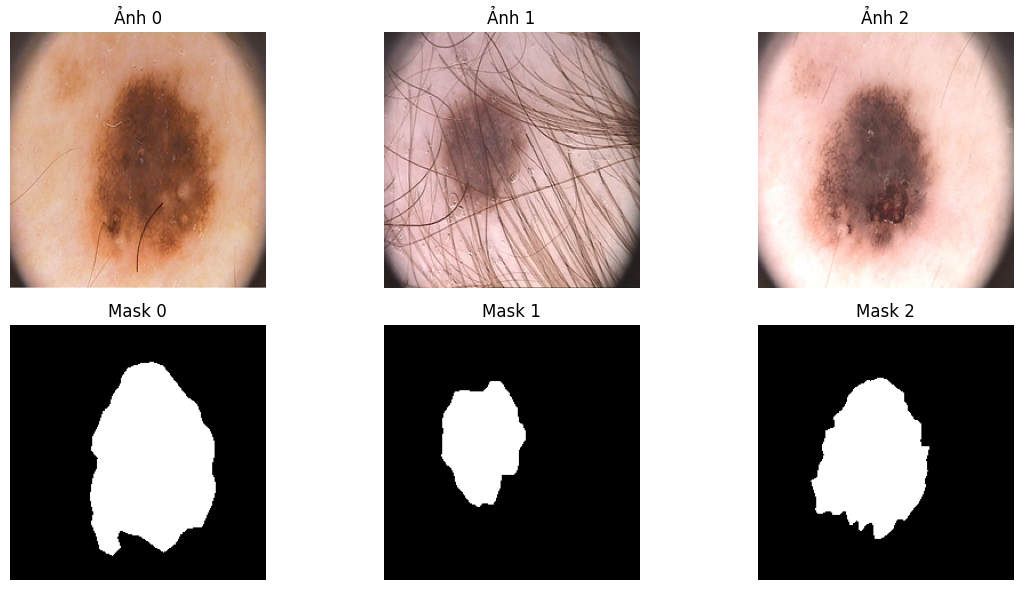

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

data_dir = '/content/drive/MyDrive/Deep Learning/Final_Examination/Segmentation/data'
mask_dir = '/content/drive/MyDrive/Deep Learning/Final_Examination/Segmentation/mask'

# Liệt kê số lượng file trong mỗi thư mục
print(f"Số lượng ảnh: {len(os.listdir(data_dir))}")
print(f"Số lượng mask: {len(os.listdir(mask_dir))}")

# Hiển thị một vài ảnh và mask tương ứng
plt.figure(figsize=(12, 6))
for i in range(3):
    # Tạo tên file theo đúng định dạng
    img_name = f'X_img_{i}.bmp'
    mask_name = f'Y_img_{i}.bmp'

    # Hiển thị ảnh gốc
    img_path = os.path.join(data_dir, img_name)
    try:
        img = np.array(Image.open(img_path))
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f'Ảnh {i}')
        plt.axis('off')
    except FileNotFoundError:
        print(f"Không tìm thấy ảnh: {img_path}")

    # Hiển thị mask tương ứng
    mask_path = os.path.join(mask_dir, mask_name)
    try:
        mask = np.array(Image.open(mask_path))
        plt.subplot(2, 3, i+4)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Mask {i}')
        plt.axis('off')
    except FileNotFoundError:
        print(f"Không tìm thấy mask: {mask_path}")

plt.tight_layout()
plt.show()

#Tạo DataSet và DataLoader

In [ ]:
class SkinCancerDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        mask_path = self.mask_paths[idx]

        # Đọc ảnh và mask
        image = Image.open(img_path)
        mask = Image.open(mask_path)

        # Chuyển mask thành NumPy array trước khi chuyển thành tensor
        mask = np.array(mask)

        # Áp dụng transform nếu có
        if self.transform:
            image = self.transform(image)

        # Chuyển mask thành tensor
        mask = torch.from_numpy(mask).unsqueeze(0).float()  # Thêm chiều kênh và chuyển sang float

        return image, mask

# Định nghĩa transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Tạo danh sách đường dẫn ảnh và mask
img_paths = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir)])
mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

# Chia tập train (80%) và validation (20%)
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
    img_paths, mask_paths, test_size=0.2, random_state=42
)

# Tạo dataset
train_dataset = SkinCancerDataset(train_img_paths, train_mask_paths, transform)
val_dataset = SkinCancerDataset(val_img_paths, val_mask_paths, transform)

# Tạo dataloader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Số mẫu trong tập huấn luyện: {len(train_dataset)}")
print(f"Số mẫu trong tập kiểm tra: {len(val_dataset)}")

Số mẫu trong tập huấn luyện: 160
Số mẫu trong tập kiểm tra: 40


#Xây dựng mô hình UNet

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder (Downsampling path)
        current_channels = in_channels
        for feature in features:
            self.downs.append(DoubleConv(current_channels, feature))
            current_channels = feature

        # Middle (Bottleneck)
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Decoder (Upsampling path)
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse skip connections
        skip_connections = skip_connections[::-1]

        # Decoder
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            # Handle case when dimensions don't match
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode="bilinear", align_corners=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        # Final convolution
        return self.final_conv(x)

# Xác định thiết bị (device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Khởi tạo model và chuyển đến thiết bị
model = UNet(in_channels=3, out_channels=1).to(device)

# Kích thước input bạn dự kiến cho mô hình (ví dụ: ảnh RGB 224x224)
input_size = (3, 224, 224)

# Sử dụng torchsummary để in ra tóm tắt mô hình
summary(model, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
        DoubleConv-7         [-1, 64, 224, 224]               0
         MaxPool2d-8         [-1, 64, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]          73,856
      BatchNorm2d-10        [-1, 128, 112, 112]             256
             ReLU-11        [-1, 128, 112, 112]               0
           Conv2d-12        [-1, 128, 112, 112]         147,584
      BatchNorm2d-13        [-1, 128, 112, 112]             256
             ReLU-14        [-1, 128, 1

#Định nghĩa Loss và các tiêu chí đánh giá

In [ ]:
# Định nghĩa hàm loss: Dice Loss kết hợp với Binary Cross Entropy
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        # BCE Loss
        bce_loss = self.bce(inputs, targets)

        # Dice Loss
        inputs_sigmoid = torch.sigmoid(inputs)
        inputs_sigmoid = inputs_sigmoid.view(-1)
        targets = targets.view(-1)
        intersection = (inputs_sigmoid * targets).sum()
        dice_loss = 1 - (2. * intersection + 1) / (inputs_sigmoid.sum() + targets.sum() + 1)

        # Kết hợp hai loss
        return bce_loss + dice_loss

# Định nghĩa optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Định nghĩa learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=5, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def dice_coef(y_pred, y_true, smooth=1):
    y_pred = torch.sigmoid(y_pred)
    y_pred_flat = y_pred.view(-1)
    y_true_flat = y_true.view(-1)
    intersection = (y_pred_flat * y_true_flat).sum()
    return (2. * intersection + smooth) / (y_pred_flat.sum() + y_true_flat.sum() + smooth)

def iou_score(y_pred, y_true, smooth=1):
    y_pred = torch.sigmoid(y_pred)
    y_pred_flat = y_pred.view(-1)
    y_true_flat = y_true.view(-1)
    intersection = (y_pred_flat * y_true_flat).sum()
    union = y_pred_flat.sum() + y_true_flat.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def pixel_accuracy(y_pred, y_true):
    y_pred = (torch.sigmoid(y_pred) > 0.5).float()
    y_pred_flat = y_pred.view(-1)
    y_true_flat = y_true.view(-1)
    correct = (y_pred_flat == y_true_flat).float().sum()
    total = y_true_flat.numel()
    return correct / total

#Xây dựng và thực hiện huấn luyện

In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_dice = 0
    epoch_iou = 0
    epoch_acc = 0

    for images, masks in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tính metrics
        dice = dice_coef(outputs, masks)
        iou = iou_score(outputs, masks)
        acc = pixel_accuracy(outputs, masks)

        # Cập nhật giá trị tổng
        epoch_loss += loss.item()
        epoch_dice += dice.item()
        epoch_iou += iou.item()
        epoch_acc += acc.item()

    # Tính giá trị trung bình
    epoch_loss /= len(dataloader)
    epoch_dice /= len(dataloader)
    epoch_iou /= len(dataloader)
    epoch_acc /= len(dataloader)

    return epoch_loss, epoch_dice, epoch_iou, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_dice = 0
    epoch_iou = 0
    epoch_acc = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation"):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Tính metrics
            dice = dice_coef(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = pixel_accuracy(outputs, masks)

            # Cập nhật giá trị tổng
            epoch_loss += loss.item()
            epoch_dice += dice.item()
            epoch_iou += iou.item()
            epoch_acc += acc.item()

    # Tính giá trị trung bình
    epoch_loss /= len(dataloader)
    epoch_dice /= len(dataloader)
    epoch_iou /= len(dataloader)
    epoch_acc /= len(dataloader)

    return epoch_loss, epoch_dice, epoch_iou, epoch_acc

In [ ]:
# Định nghĩa số epoch
num_epochs = 100

# Khởi tạo criterion
criterion = DiceBCELoss()

# Khởi tạo các list để lưu kết quả
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_dices = []
val_dices = []
train_ious = []
val_ious = []

# Theo dõi epoch tốt nhất dựa trên val_loss và early stopping
best_val_loss = float('inf')
best_epoch = -1
patience = 10  # Số epoch không có cải thiện trên validation loss để dừng
epochs_no_improve = 0

# Thực hiện huấn luyện
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Huấn luyện một epoch
    train_loss, train_dice, train_iou, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)

    # Đánh giá trên tập validation
    val_loss, val_dice, val_iou, val_acc = validate(model, val_loader, criterion, device)

    # Cập nhật learning rate
    scheduler.step(val_loss)

    # Lưu kết quả
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_dices.append(train_dice)
    val_dices.append(val_dice)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    # In kết quả
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}")
    print("-" * 50)

    # Theo dõi epoch tốt nhất và early stopping dựa trên val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model_val_loss.pth')
        print(f"Validation loss improved. Saving model at epoch {best_epoch}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"Epochs without improvement: {epochs_no_improve}")
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

print(f"Training finished! Best epoch based on Validation Loss: {best_epoch} (Val Loss: {best_val_loss:.4f})")

Epoch 1/100


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Train Loss: 0.9065, Train Acc: 0.8208, Train Dice: 0.5554, Train IoU: 0.3907
Val Loss: 1.0178, Val Acc: 0.8531, Val Dice: 0.4985, Val IoU: 0.3326
--------------------------------------------------
Validation loss improved. Saving model at epoch 1
Epoch 2/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]


Train Loss: 0.6561, Train Acc: 0.9057, Train Dice: 0.6699, Train IoU: 0.5058
Val Loss: 0.5303, Val Acc: 0.9194, Val Dice: 0.7387, Val IoU: 0.5871
--------------------------------------------------
Validation loss improved. Saving model at epoch 2
Epoch 3/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.10it/s]


Train Loss: 0.6422, Train Acc: 0.8953, Train Dice: 0.6790, Train IoU: 0.5165
Val Loss: 0.4943, Val Acc: 0.9232, Val Dice: 0.7633, Val IoU: 0.6184
--------------------------------------------------
Validation loss improved. Saving model at epoch 3
Epoch 4/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.21it/s]


Train Loss: 0.5397, Train Acc: 0.9311, Train Dice: 0.7218, Train IoU: 0.5659
Val Loss: 0.5425, Val Acc: 0.9213, Val Dice: 0.7279, Val IoU: 0.5735
--------------------------------------------------
Epochs without improvement: 1
Epoch 5/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.95it/s]


Train Loss: 0.5414, Train Acc: 0.9237, Train Dice: 0.7250, Train IoU: 0.5728
Val Loss: 0.4709, Val Acc: 0.9281, Val Dice: 0.7730, Val IoU: 0.6307
--------------------------------------------------
Validation loss improved. Saving model at epoch 5
Epoch 6/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.92it/s]


Train Loss: 0.5258, Train Acc: 0.9294, Train Dice: 0.7272, Train IoU: 0.5762
Val Loss: 0.4881, Val Acc: 0.9115, Val Dice: 0.7682, Val IoU: 0.6244
--------------------------------------------------
Epochs without improvement: 1
Epoch 7/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.78it/s]


Train Loss: 0.5687, Train Acc: 0.9097, Train Dice: 0.7136, Train IoU: 0.5602
Val Loss: 0.4615, Val Acc: 0.9132, Val Dice: 0.7827, Val IoU: 0.6436
--------------------------------------------------
Validation loss improved. Saving model at epoch 7
Epoch 8/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


Train Loss: 0.5105, Train Acc: 0.9251, Train Dice: 0.7416, Train IoU: 0.5913
Val Loss: 0.3962, Val Acc: 0.9434, Val Dice: 0.8041, Val IoU: 0.6732
--------------------------------------------------
Validation loss improved. Saving model at epoch 8
Epoch 9/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]


Train Loss: 0.4930, Train Acc: 0.9249, Train Dice: 0.7511, Train IoU: 0.6038
Val Loss: 0.4236, Val Acc: 0.9312, Val Dice: 0.7956, Val IoU: 0.6615
--------------------------------------------------
Epochs without improvement: 1
Epoch 10/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.72it/s]


Train Loss: 0.4715, Train Acc: 0.9301, Train Dice: 0.7582, Train IoU: 0.6136
Val Loss: 0.4216, Val Acc: 0.9283, Val Dice: 0.7988, Val IoU: 0.6659
--------------------------------------------------
Epochs without improvement: 2
Epoch 11/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


Train Loss: 0.4351, Train Acc: 0.9417, Train Dice: 0.7738, Train IoU: 0.6331
Val Loss: 0.3975, Val Acc: 0.9364, Val Dice: 0.8026, Val IoU: 0.6705
--------------------------------------------------
Epochs without improvement: 3
Epoch 12/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


Train Loss: 0.4435, Train Acc: 0.9308, Train Dice: 0.7751, Train IoU: 0.6362
Val Loss: 0.3742, Val Acc: 0.9450, Val Dice: 0.8161, Val IoU: 0.6902
--------------------------------------------------
Validation loss improved. Saving model at epoch 12
Epoch 13/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.74it/s]


Train Loss: 0.4427, Train Acc: 0.9316, Train Dice: 0.7741, Train IoU: 0.6344
Val Loss: 0.3630, Val Acc: 0.9446, Val Dice: 0.8178, Val IoU: 0.6927
--------------------------------------------------
Validation loss improved. Saving model at epoch 13
Epoch 14/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s]


Train Loss: 0.4209, Train Acc: 0.9369, Train Dice: 0.7843, Train IoU: 0.6477
Val Loss: 0.3782, Val Acc: 0.9423, Val Dice: 0.8133, Val IoU: 0.6862
--------------------------------------------------
Epochs without improvement: 1
Epoch 15/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.87it/s]


Train Loss: 0.3943, Train Acc: 0.9432, Train Dice: 0.7992, Train IoU: 0.6669
Val Loss: 0.3699, Val Acc: 0.9422, Val Dice: 0.8216, Val IoU: 0.6980
--------------------------------------------------
Epochs without improvement: 2
Epoch 16/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]


Train Loss: 0.4041, Train Acc: 0.9382, Train Dice: 0.7921, Train IoU: 0.6599
Val Loss: 0.3432, Val Acc: 0.9414, Val Dice: 0.8335, Val IoU: 0.7150
--------------------------------------------------
Validation loss improved. Saving model at epoch 16
Epoch 17/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


Train Loss: 0.4009, Train Acc: 0.9387, Train Dice: 0.7945, Train IoU: 0.6633
Val Loss: 0.3189, Val Acc: 0.9471, Val Dice: 0.8454, Val IoU: 0.7330
--------------------------------------------------
Validation loss improved. Saving model at epoch 17
Epoch 18/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.93it/s]


Train Loss: 0.3865, Train Acc: 0.9397, Train Dice: 0.8042, Train IoU: 0.6762
Val Loss: 0.3175, Val Acc: 0.9440, Val Dice: 0.8481, Val IoU: 0.7369
--------------------------------------------------
Validation loss improved. Saving model at epoch 18
Epoch 19/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


Train Loss: 0.3937, Train Acc: 0.9384, Train Dice: 0.8000, Train IoU: 0.6706
Val Loss: 0.3502, Val Acc: 0.9453, Val Dice: 0.8292, Val IoU: 0.7092
--------------------------------------------------
Epochs without improvement: 1
Epoch 20/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


Train Loss: 0.3880, Train Acc: 0.9367, Train Dice: 0.8030, Train IoU: 0.6745
Val Loss: 0.3423, Val Acc: 0.9420, Val Dice: 0.8328, Val IoU: 0.7141
--------------------------------------------------
Epochs without improvement: 2
Epoch 21/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


Train Loss: 0.3432, Train Acc: 0.9448, Train Dice: 0.8239, Train IoU: 0.7020
Val Loss: 0.3307, Val Acc: 0.9366, Val Dice: 0.8504, Val IoU: 0.7404
--------------------------------------------------
Epochs without improvement: 3
Epoch 22/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


Train Loss: 0.3331, Train Acc: 0.9527, Train Dice: 0.8273, Train IoU: 0.7078
Val Loss: 0.2979, Val Acc: 0.9522, Val Dice: 0.8540, Val IoU: 0.7457
--------------------------------------------------
Validation loss improved. Saving model at epoch 22
Epoch 23/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s]


Train Loss: 0.3240, Train Acc: 0.9516, Train Dice: 0.8332, Train IoU: 0.7172
Val Loss: 0.3486, Val Acc: 0.9286, Val Dice: 0.8434, Val IoU: 0.7303
--------------------------------------------------
Epochs without improvement: 1
Epoch 24/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


Train Loss: 0.3028, Train Acc: 0.9562, Train Dice: 0.8421, Train IoU: 0.7293
Val Loss: 0.2914, Val Acc: 0.9519, Val Dice: 0.8579, Val IoU: 0.7516
--------------------------------------------------
Validation loss improved. Saving model at epoch 24
Epoch 25/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.89it/s]


Train Loss: 0.2842, Train Acc: 0.9594, Train Dice: 0.8536, Train IoU: 0.7459
Val Loss: 0.2840, Val Acc: 0.9503, Val Dice: 0.8641, Val IoU: 0.7611
--------------------------------------------------
Validation loss improved. Saving model at epoch 25
Epoch 26/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.84it/s]


Train Loss: 0.3111, Train Acc: 0.9523, Train Dice: 0.8449, Train IoU: 0.7339
Val Loss: 0.3629, Val Acc: 0.9208, Val Dice: 0.8441, Val IoU: 0.7310
--------------------------------------------------
Epochs without improvement: 1
Epoch 27/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.72it/s]


Train Loss: 0.3843, Train Acc: 0.9317, Train Dice: 0.8110, Train IoU: 0.6877
Val Loss: 0.2707, Val Acc: 0.9503, Val Dice: 0.8694, Val IoU: 0.7693
--------------------------------------------------
Validation loss improved. Saving model at epoch 27
Epoch 28/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


Train Loss: 0.3061, Train Acc: 0.9511, Train Dice: 0.8429, Train IoU: 0.7302
Val Loss: 0.2992, Val Acc: 0.9459, Val Dice: 0.8596, Val IoU: 0.7543
--------------------------------------------------
Epochs without improvement: 1
Epoch 29/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.97it/s]


Train Loss: 0.3084, Train Acc: 0.9506, Train Dice: 0.8444, Train IoU: 0.7330
Val Loss: 0.2772, Val Acc: 0.9503, Val Dice: 0.8685, Val IoU: 0.7683
--------------------------------------------------
Epochs without improvement: 2
Epoch 30/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.72it/s]


Train Loss: 0.2760, Train Acc: 0.9588, Train Dice: 0.8577, Train IoU: 0.7538
Val Loss: 0.2715, Val Acc: 0.9552, Val Dice: 0.8701, Val IoU: 0.7704
--------------------------------------------------
Epochs without improvement: 3
Epoch 31/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.92it/s]


Train Loss: 0.3043, Train Acc: 0.9489, Train Dice: 0.8508, Train IoU: 0.7424
Val Loss: 0.2913, Val Acc: 0.9387, Val Dice: 0.8729, Val IoU: 0.7752
--------------------------------------------------
Epochs without improvement: 4
Epoch 32/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.91it/s]


Train Loss: 0.2727, Train Acc: 0.9552, Train Dice: 0.8617, Train IoU: 0.7583
Val Loss: 0.2503, Val Acc: 0.9562, Val Dice: 0.8792, Val IoU: 0.7848
--------------------------------------------------
Validation loss improved. Saving model at epoch 32
Epoch 33/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


Train Loss: 0.2860, Train Acc: 0.9524, Train Dice: 0.8572, Train IoU: 0.7536
Val Loss: 0.2963, Val Acc: 0.9394, Val Dice: 0.8670, Val IoU: 0.7665
--------------------------------------------------
Epochs without improvement: 1
Epoch 34/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.96it/s]


Train Loss: 0.2836, Train Acc: 0.9532, Train Dice: 0.8572, Train IoU: 0.7515
Val Loss: 0.2583, Val Acc: 0.9490, Val Dice: 0.8818, Val IoU: 0.7890
--------------------------------------------------
Epochs without improvement: 2
Epoch 35/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]


Train Loss: 0.2649, Train Acc: 0.9589, Train Dice: 0.8636, Train IoU: 0.7643
Val Loss: 0.2754, Val Acc: 0.9469, Val Dice: 0.8744, Val IoU: 0.7778
--------------------------------------------------
Epochs without improvement: 3
Epoch 36/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


Train Loss: 0.2476, Train Acc: 0.9613, Train Dice: 0.8734, Train IoU: 0.7772
Val Loss: 0.2497, Val Acc: 0.9549, Val Dice: 0.8813, Val IoU: 0.7883
--------------------------------------------------
Validation loss improved. Saving model at epoch 36
Epoch 37/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.96it/s]


Train Loss: 0.2396, Train Acc: 0.9635, Train Dice: 0.8800, Train IoU: 0.7873
Val Loss: 0.2480, Val Acc: 0.9519, Val Dice: 0.8897, Val IoU: 0.8016
--------------------------------------------------
Validation loss improved. Saving model at epoch 37
Epoch 38/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.95it/s]


Train Loss: 0.2411, Train Acc: 0.9630, Train Dice: 0.8787, Train IoU: 0.7854
Val Loss: 0.2359, Val Acc: 0.9527, Val Dice: 0.8925, Val IoU: 0.8065
--------------------------------------------------
Validation loss improved. Saving model at epoch 38
Epoch 39/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


Train Loss: 0.2423, Train Acc: 0.9630, Train Dice: 0.8744, Train IoU: 0.7799
Val Loss: 0.2830, Val Acc: 0.9420, Val Dice: 0.8755, Val IoU: 0.7796
--------------------------------------------------
Epochs without improvement: 1
Epoch 40/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.99it/s]


Train Loss: 0.2876, Train Acc: 0.9480, Train Dice: 0.8610, Train IoU: 0.7580
Val Loss: 0.2444, Val Acc: 0.9518, Val Dice: 0.8911, Val IoU: 0.8041
--------------------------------------------------
Epochs without improvement: 2
Epoch 41/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.01it/s]


Train Loss: 0.2700, Train Acc: 0.9546, Train Dice: 0.8684, Train IoU: 0.7699
Val Loss: 0.2892, Val Acc: 0.9389, Val Dice: 0.8734, Val IoU: 0.7761
--------------------------------------------------
Epochs without improvement: 3
Epoch 42/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.31it/s]


Train Loss: 0.2418, Train Acc: 0.9599, Train Dice: 0.8771, Train IoU: 0.7824
Val Loss: 0.2645, Val Acc: 0.9501, Val Dice: 0.8773, Val IoU: 0.7822
--------------------------------------------------
Epochs without improvement: 4
Epoch 43/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.73it/s]


Train Loss: 0.2512, Train Acc: 0.9560, Train Dice: 0.8756, Train IoU: 0.7823
Val Loss: 0.2449, Val Acc: 0.9480, Val Dice: 0.8953, Val IoU: 0.8108
--------------------------------------------------
Epochs without improvement: 5
Epoch 44/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.07it/s]


Train Loss: 0.2174, Train Acc: 0.9643, Train Dice: 0.8899, Train IoU: 0.8030
Val Loss: 0.2186, Val Acc: 0.9590, Val Dice: 0.8972, Val IoU: 0.8139
--------------------------------------------------
Validation loss improved. Saving model at epoch 44
Epoch 45/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.68it/s]


Train Loss: 0.2154, Train Acc: 0.9650, Train Dice: 0.8946, Train IoU: 0.8103
Val Loss: 0.2212, Val Acc: 0.9569, Val Dice: 0.9011, Val IoU: 0.8201
--------------------------------------------------
Epochs without improvement: 1
Epoch 46/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.06it/s]


Train Loss: 0.2081, Train Acc: 0.9667, Train Dice: 0.8935, Train IoU: 0.8096
Val Loss: 0.2117, Val Acc: 0.9603, Val Dice: 0.9027, Val IoU: 0.8231
--------------------------------------------------
Validation loss improved. Saving model at epoch 46
Epoch 47/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]


Train Loss: 0.2049, Train Acc: 0.9664, Train Dice: 0.8994, Train IoU: 0.8184
Val Loss: 0.2166, Val Acc: 0.9579, Val Dice: 0.9058, Val IoU: 0.8282
--------------------------------------------------
Epochs without improvement: 1
Epoch 48/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


Train Loss: 0.1799, Train Acc: 0.9718, Train Dice: 0.9076, Train IoU: 0.8317
Val Loss: 0.2258, Val Acc: 0.9537, Val Dice: 0.9032, Val IoU: 0.8242
--------------------------------------------------
Epochs without improvement: 2
Epoch 49/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.95it/s]


Train Loss: 0.1820, Train Acc: 0.9719, Train Dice: 0.9078, Train IoU: 0.8328
Val Loss: 0.2361, Val Acc: 0.9514, Val Dice: 0.8970, Val IoU: 0.8138
--------------------------------------------------
Epochs without improvement: 3
Epoch 50/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.85it/s]


Train Loss: 0.1784, Train Acc: 0.9704, Train Dice: 0.9109, Train IoU: 0.8371
Val Loss: 0.2207, Val Acc: 0.9548, Val Dice: 0.9069, Val IoU: 0.8300
--------------------------------------------------
Epochs without improvement: 4
Epoch 51/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


Train Loss: 0.1795, Train Acc: 0.9724, Train Dice: 0.9072, Train IoU: 0.8319
Val Loss: 0.2474, Val Acc: 0.9497, Val Dice: 0.8981, Val IoU: 0.8155
--------------------------------------------------
Epochs without improvement: 5
Epoch 52/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.89it/s]


Train Loss: 0.1643, Train Acc: 0.9738, Train Dice: 0.9169, Train IoU: 0.8472
Val Loss: 0.2020, Val Acc: 0.9597, Val Dice: 0.9138, Val IoU: 0.8416
--------------------------------------------------
Validation loss improved. Saving model at epoch 52
Epoch 53/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.87it/s]


Train Loss: 0.1574, Train Acc: 0.9758, Train Dice: 0.9193, Train IoU: 0.8515
Val Loss: 0.2239, Val Acc: 0.9564, Val Dice: 0.9087, Val IoU: 0.8334
--------------------------------------------------
Epochs without improvement: 1
Epoch 54/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


Train Loss: 0.1631, Train Acc: 0.9755, Train Dice: 0.9161, Train IoU: 0.8470
Val Loss: 0.2084, Val Acc: 0.9582, Val Dice: 0.9135, Val IoU: 0.8412
--------------------------------------------------
Epochs without improvement: 2
Epoch 55/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.88it/s]


Train Loss: 0.1564, Train Acc: 0.9742, Train Dice: 0.9215, Train IoU: 0.8553
Val Loss: 0.2084, Val Acc: 0.9587, Val Dice: 0.9120, Val IoU: 0.8387
--------------------------------------------------
Epochs without improvement: 3
Epoch 56/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.02it/s]


Train Loss: 0.1685, Train Acc: 0.9731, Train Dice: 0.9144, Train IoU: 0.8437
Val Loss: 0.2267, Val Acc: 0.9540, Val Dice: 0.9097, Val IoU: 0.8349
--------------------------------------------------
Epochs without improvement: 4
Epoch 57/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]


Train Loss: 0.1594, Train Acc: 0.9747, Train Dice: 0.9196, Train IoU: 0.8524
Val Loss: 0.2262, Val Acc: 0.9555, Val Dice: 0.9095, Val IoU: 0.8348
--------------------------------------------------
Epochs without improvement: 5
Epoch 58/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.84it/s]


Train Loss: 0.1450, Train Acc: 0.9765, Train Dice: 0.9266, Train IoU: 0.8639
Val Loss: 0.2098, Val Acc: 0.9581, Val Dice: 0.9158, Val IoU: 0.8454
--------------------------------------------------
Epochs without improvement: 6
Epoch 59/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.81it/s]


Train Loss: 0.1373, Train Acc: 0.9787, Train Dice: 0.9296, Train IoU: 0.8697
Val Loss: 0.2088, Val Acc: 0.9581, Val Dice: 0.9177, Val IoU: 0.8486
--------------------------------------------------
Epochs without improvement: 7
Epoch 60/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]


Train Loss: 0.1433, Train Acc: 0.9785, Train Dice: 0.9238, Train IoU: 0.8610
Val Loss: 0.2028, Val Acc: 0.9593, Val Dice: 0.9187, Val IoU: 0.8501
--------------------------------------------------
Epochs without improvement: 8
Epoch 61/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.96it/s]


Train Loss: 0.1367, Train Acc: 0.9806, Train Dice: 0.9271, Train IoU: 0.8654
Val Loss: 0.2023, Val Acc: 0.9595, Val Dice: 0.9181, Val IoU: 0.8491
--------------------------------------------------
Epochs without improvement: 9
Epoch 62/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.91it/s]

Train Loss: 0.1243, Train Acc: 0.9814, Train Dice: 0.9358, Train IoU: 0.8800
Val Loss: 0.2062, Val Acc: 0.9586, Val Dice: 0.9184, Val IoU: 0.8497
--------------------------------------------------
Epochs without improvement: 10
Early stopping triggered after 10 epochs without improvement.
Training finished! Best epoch based on Validation Loss: 52 (Val Loss: 0.2020)


#Hiển thị kết quả huấn luyện

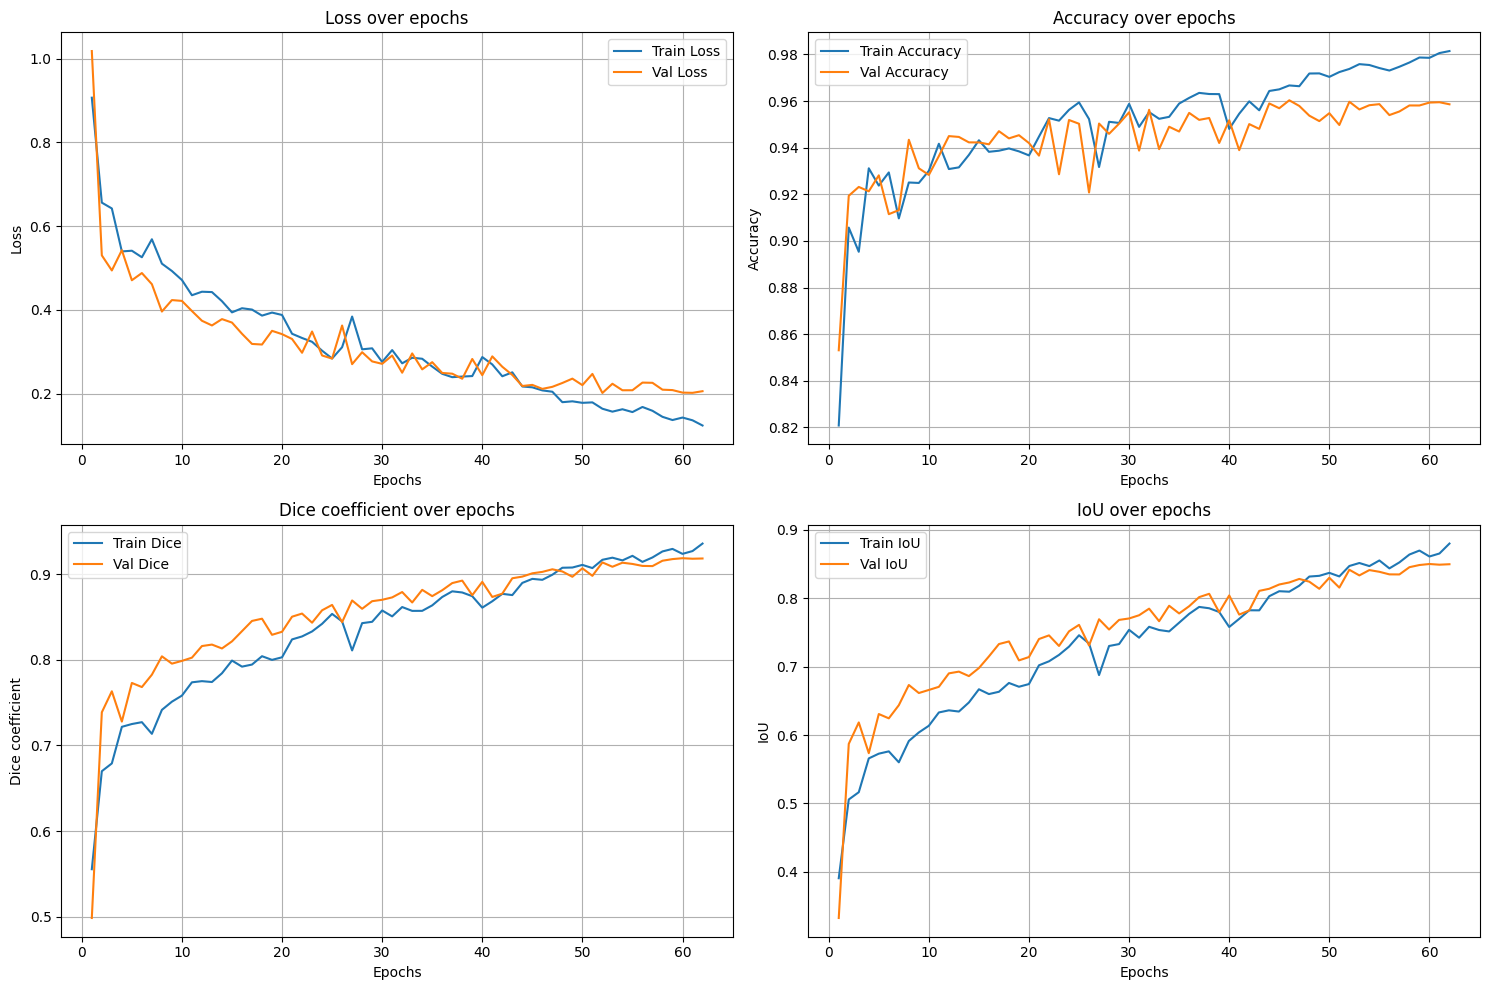

In [ ]:
# Vẽ đồ thị kết quả huấn luyện
plt.figure(figsize=(15, 10))
num_epochs_trained = len(train_losses)  # Lấy số epoch thực tế đã huấn luyện

# Vẽ đồ thị loss
plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs_trained + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs_trained + 1), val_losses, label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Vẽ đồ thị accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs_trained + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs_trained + 1), val_accuracies, label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Vẽ đồ thị Dice coefficient
plt.subplot(2, 2, 3)
plt.plot(range(1, num_epochs_trained + 1), train_dices, label='Train Dice')
plt.plot(range(1, num_epochs_trained + 1), val_dices, label='Val Dice')
plt.title('Dice coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice coefficient')
plt.legend()
plt.grid(True)

# Vẽ đồ thị IoU
plt.subplot(2, 2, 4)
plt.plot(range(1, num_epochs_trained + 1), train_ious, label='Train IoU')
plt.plot(range(1, num_epochs_trained + 1), val_ious, label='Val IoU')
plt.title('IoU over epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_results.png')
plt.show()

#Hiển thị kết quả phân vùng trên tập Validation

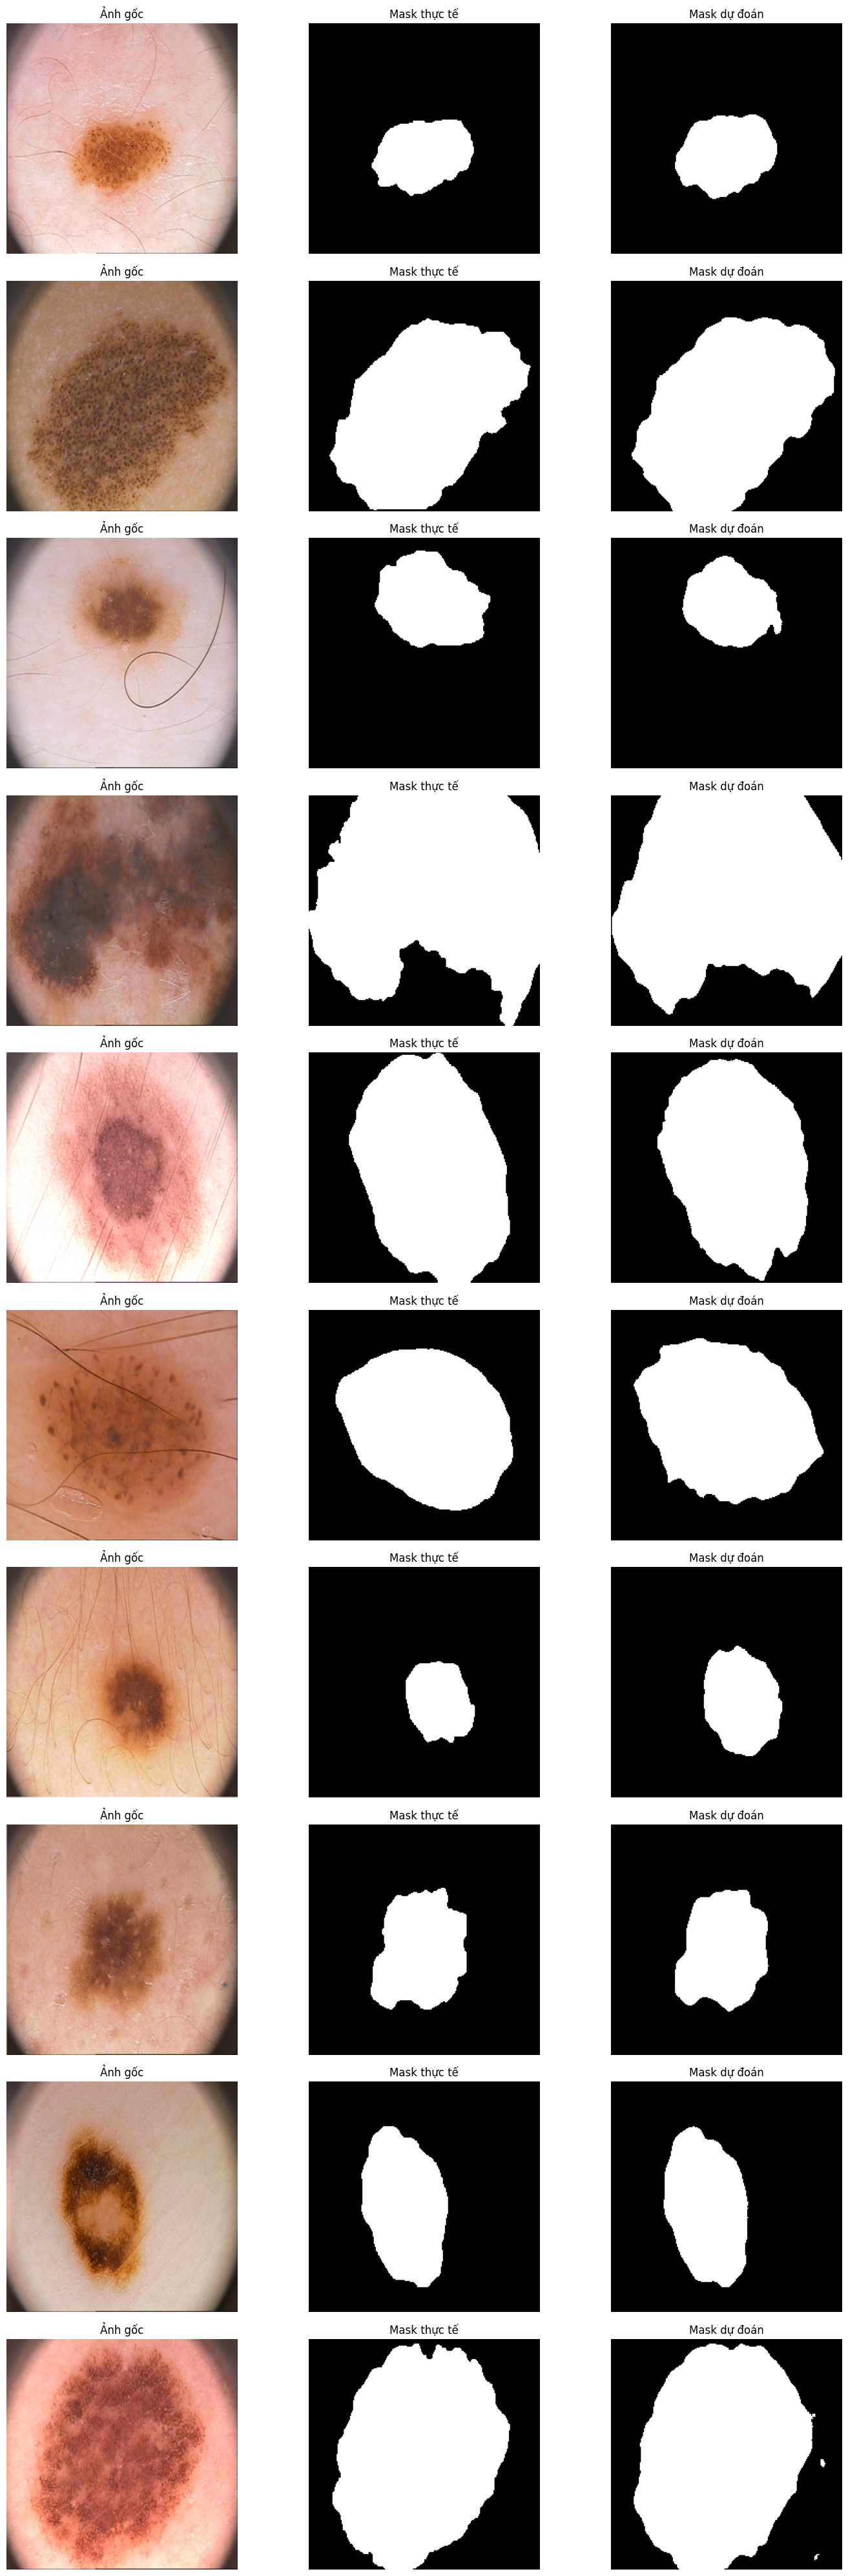

In [ ]:
import random

def visualize_predictions(model, dataloader, device, num_samples=10):
    model.eval()
    all_images = []
    all_masks = []

    # Lấy tất cả ảnh và mask từ dataloader (có thể tốn bộ nhớ nếu dataset lớn)
    for images, masks in dataloader:
        all_images.append(images.cpu())
        all_masks.append(masks.cpu())

    if not all_images:
        print("Validation dataloader is empty.")
        return

    all_images = torch.cat(all_images, dim=0)
    all_masks = torch.cat(all_masks, dim=0)

    num_total_samples = len(all_images)
    num_samples_to_visualize = min(num_samples, num_total_samples)

    # Chọn ngẫu nhiên các index
    random_indices = random.sample(range(num_total_samples), num_samples_to_visualize)

    # Lấy các mẫu ngẫu nhiên
    selected_images = all_images[random_indices].to(device)
    selected_masks = all_masks[random_indices].to(device)

    # Dự đoán
    with torch.no_grad():
        preds = model(selected_images)
        preds = torch.sigmoid(preds) > 0.5

    # Chuyển về numpy để hiển thị
    images_np = selected_images.cpu().numpy()
    masks_np = selected_masks.cpu().numpy()
    preds_np = preds.cpu().numpy()

    # Hiển thị kết quả
    plt.figure(figsize=(15, num_samples_to_visualize * 4))

    for i in range(num_samples_to_visualize):
        img = images_np[i].transpose(1, 2, 0)
        # Denormalize ảnh (sử dụng mean và std bạn đã dùng trong transform)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = (img * std) + mean
        img = np.clip(img, 0, 1)

        mask = masks_np[i, 0]
        pred = preds_np[i, 0]

        # Hiển thị ảnh gốc
        plt.subplot(num_samples_to_visualize, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title('Ảnh gốc')
        plt.axis('off')

        # Hiển thị mask thực tế
        plt.subplot(num_samples_to_visualize, 3, i * 3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask thực tế')
        plt.axis('off')

        # Hiển thị mask dự đoán
        plt.subplot(num_samples_to_visualize, 3, i * 3 + 3)
        plt.imshow(pred, cmap='gray')
        plt.title('Mask dự đoán')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('prediction_results.png')
    plt.show()

# Tạo lại instance của mô hình (đảm bảo kiến trúc giống hệt)
model_at_epoch_n = UNet(in_channels=3, out_channels=1).to(device)
# Tải lại trạng thái đã lưu
model_at_epoch_n.load_state_dict(torch.load('best_model_val_loss.pth'))
# Gọi hàm visualize với mô hình đã tải
visualize_predictions(model_at_epoch_n, val_loader, device, num_samples=10)